MULTI-STAGE MANUFACTURING PROCESS - PREDICTIVE MODELING
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

📁 Loading dataset...
✓ Dataset loaded successfully: 14088 rows × 116 columns

EXPLORATORY DATA ANALYSIS

📊 Dataset Overview:
            time_stamp  AmbientConditions.AmbientHumidity.U.Actual  \
0  2019-03-06 10:52:33                                       17.24   
1  2019-03-06 10:52:34                                       17.24   
2  2019-03-06 10:52:35                                       17.24   
3  2019-03-06 10:52:36                                       17.24   
4  2019-03-06 10:52:37                                       17.24   

   AmbientConditions.AmbientTemperature.U.Actual  \
0                                          23.53   
1                                          23.53   
2                                          23.53   
3                                          23.53   
4       

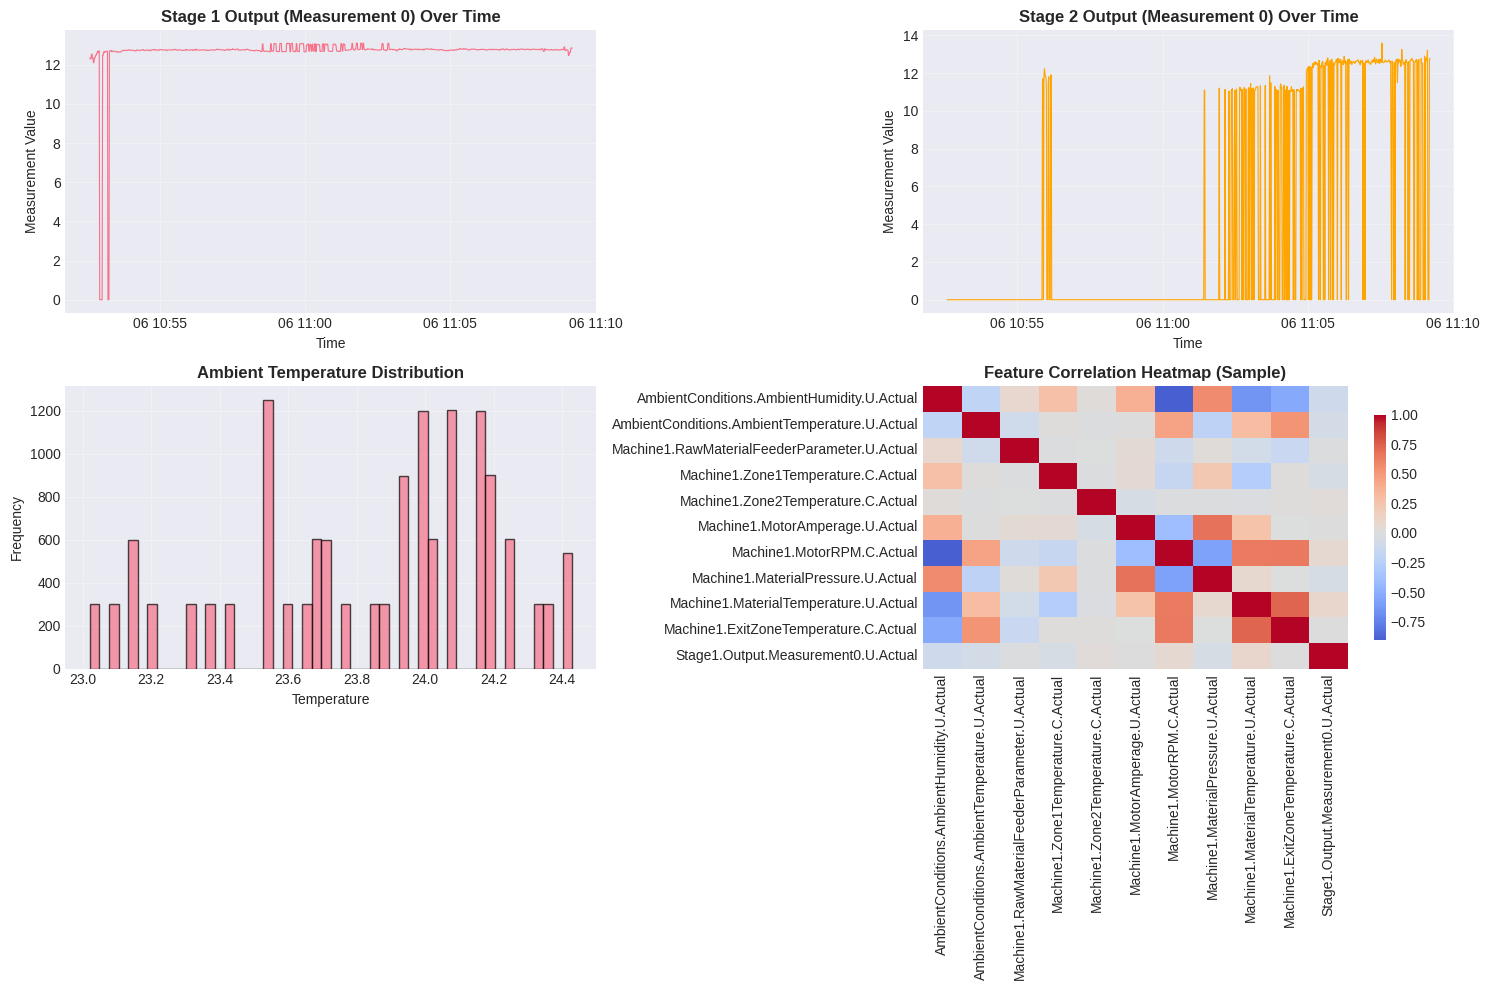


✓ Visualizations saved as 'eda_visualizations.png'

STAGE 1: MODEL TRAINING

📊 Training set: 11268 samples
📊 Test set: 2818 samples

🤖 Training models for Stage 1 - Measurement 0...

⚙️  Training Random Forest...
   RMSE: 0.2228
   MAE:  0.0833
   R²:   -21.5810

⚙️  Training XGBoost...
   RMSE: 0.1604
   MAE:  0.1349
   R²:   -10.6927

⚙️  Training Gradient Boosting...
   RMSE: 0.1463
   MAE:  0.1014
   R²:   -8.7327

⚙️  Training Ridge...
   RMSE: 0.2747
   MAE:  0.2356
   R²:   -33.3233

STAGE 1 MODEL COMPARISON (Measurement 0)
                        MSE      RMSE       MAE         R2
Random Forest      0.049658  0.222842  0.083302 -21.580993
XGBoost            0.025714  0.160355  0.134859 -10.692706
Gradient Boosting  0.021404  0.146299  0.101376  -8.732745
Ridge              0.075481  0.274739  0.235595 -33.323306

🏆 Best Model for Stage 1: Gradient Boosting

STAGE 2: MODEL TRAINING

🤖 Training models for Stage 2 - Measurement 0...

⚙️  Training Random Forest...
   RMSE: 4.1251


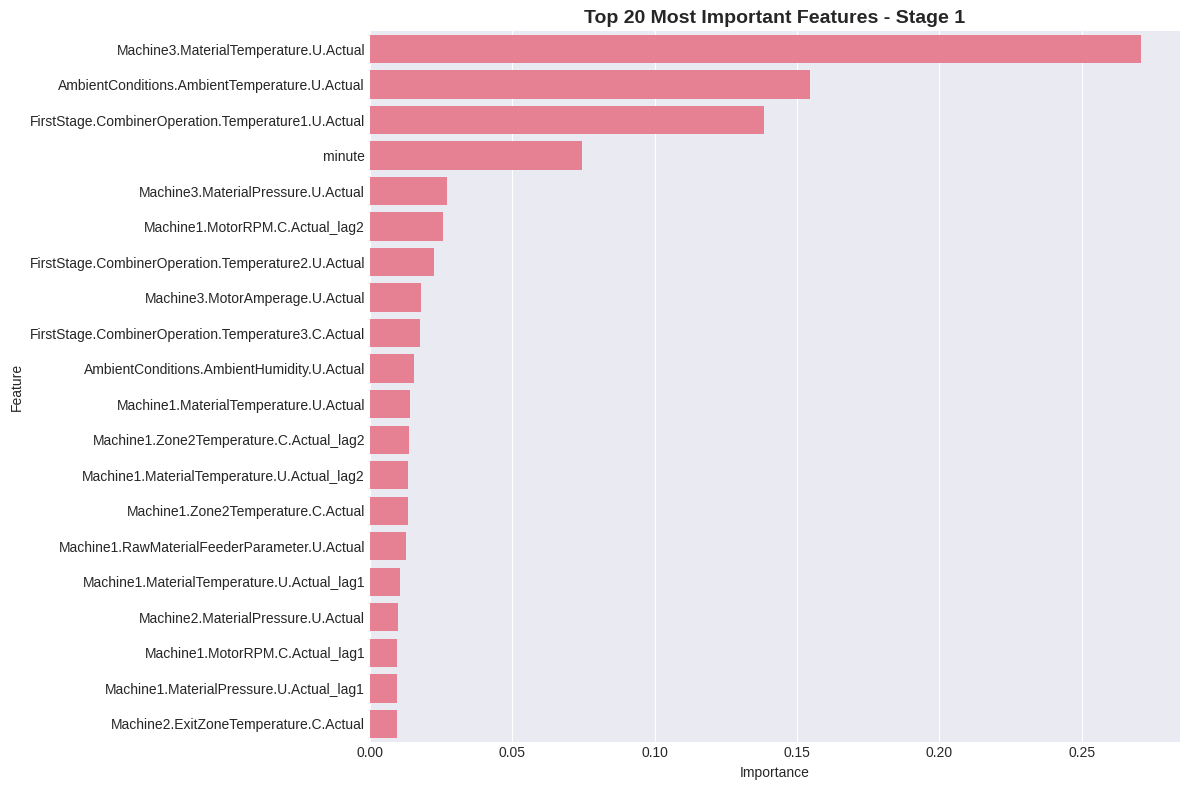


PREDICTION VISUALIZATION


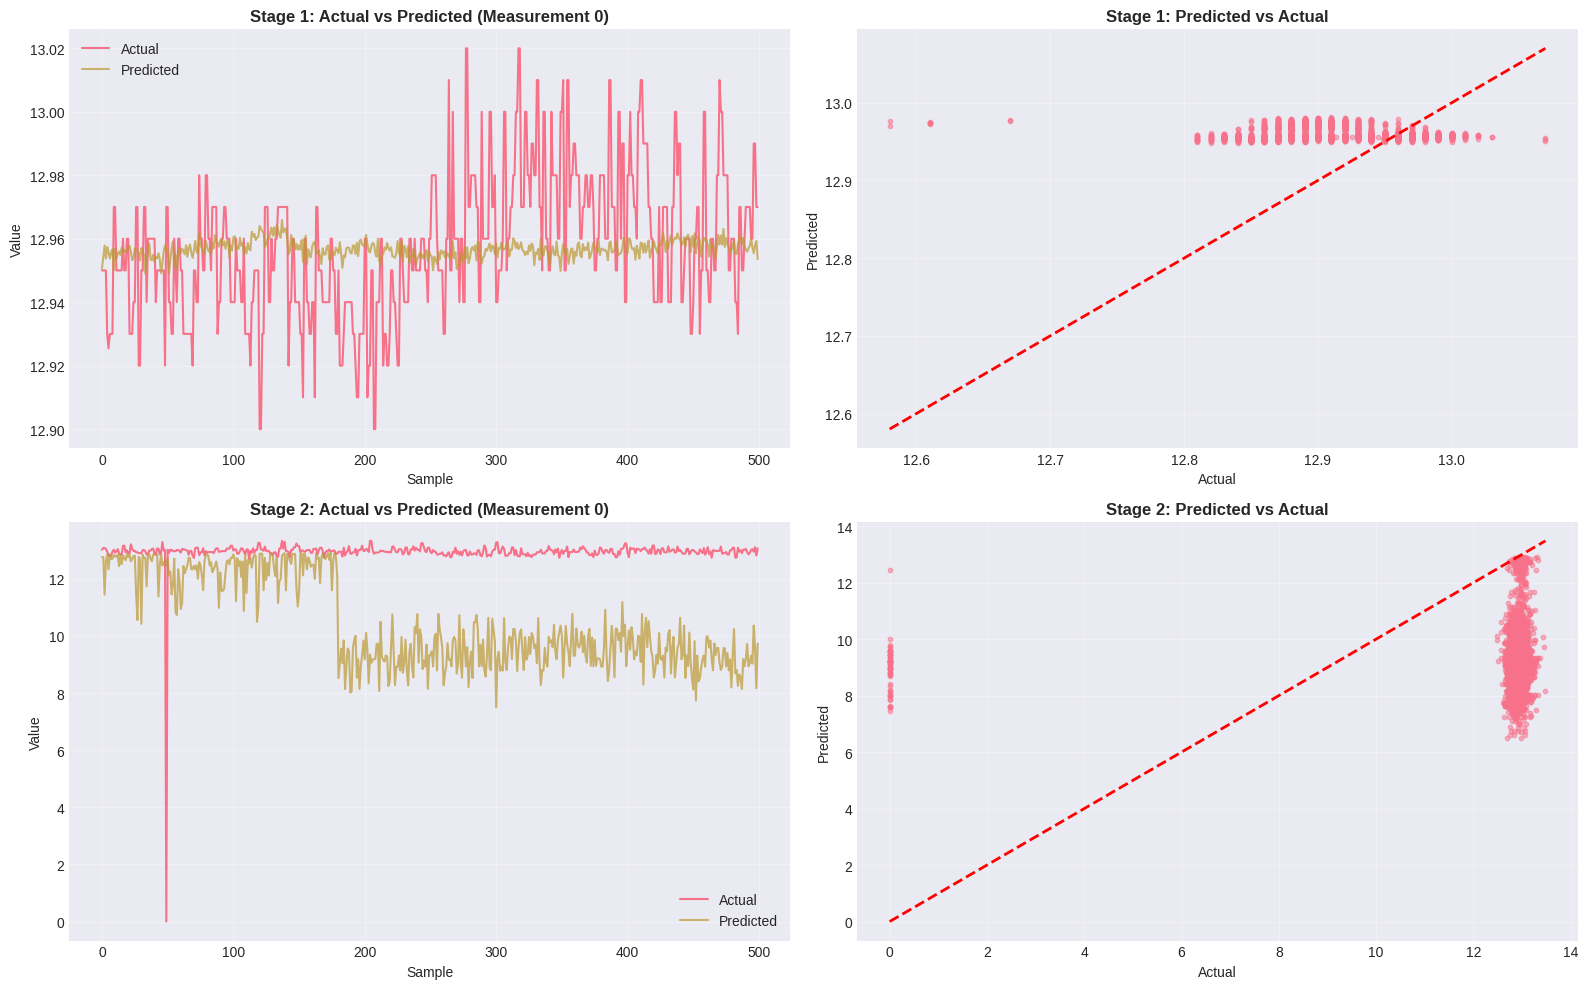


MODEL DEPLOYMENT PREPARATION

✓ Models saved successfully:
  - stage1_model.pkl
  - stage2_model.pkl
  - scaler_stage1.pkl
  - scaler_stage2.pkl

✓ Prediction function created: predict_factory_output()

PROJECT SUMMARY

📊 Dataset Summary:
   - Total samples: 14086
   - Features: 128
   - Sample rate: 1 Hz
   
🎯 Prediction Targets:
   - Stage 1: 15 measurements (after parallel machines + combiner)
   - Stage 2: 15 measurements (after series machines)
   
🤖 Best Models:
   - Stage 1: Gradient Boosting
   - Stage 2: Ridge
   
📈 Average Performance (Measurement 0):
   Stage 1:
   - R²: -1.0153
   - RMSE: 0.0666
   
   Stage 2:
   - R²: -3.3092
   - RMSE: 3.9720

🎨 Visualizations Generated:
   - eda_visualizations.png
   - feature_importance_stage1.png
   - predictions_visualization.png
   
💾 Models Saved:
   - stage1_model.pkl
   - stage2_model.pkl
   - scaler_stage1.pkl
   - scaler_stage2.pkl

✅ Ready for deployment in real-time production environment!

PROJECT COMPLETE


In [7]:
# Multi-Stage Continuous-Flow Manufacturing Process Prediction
# Google Colab Implementation

"""
Project: Predict factory output from a multi-stage manufacturing process
- Stage 1: 3 parallel machines → combiner → 15 measurement locations
- Stage 2: 2 series machines → 15 measurement locations
Sample Rate: 1 Hz
"""

# ============================================================================
# 1. INSTALLATION AND IMPORTS
# ============================================================================

!pip install -q xgboost scikit-learn pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# 2. DATA LOADING
# ============================================================================

print("=" * 80)
print("MULTI-STAGE MANUFACTURING PROCESS - PREDICTIVE MODELING")
print("=" * 80)

# Mount Google Drive (if using file from Drive)
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
# Option 1: From Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/continuous_factory_process.csv'


# Option 2: Upload directly
# from google.colab import files
# uploaded = files.upload()
# file_path = 'continuous_factory_process.csv'

# Option 3: From URL (if accessible)
# file_path = 'URL_TO_CSV'

print("\n📁 Loading dataset...")
df = pd.read_csv(file_path)
print(f"✓ Dataset loaded successfully: {df.shape[0]} rows × {df.shape[1]} columns")

# ============================================================================
# 3. EXPLORATORY DATA ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Basic information
print("\n📊 Dataset Overview:")
print(df.head())
print("\n📋 Data Types:")
print(df.dtypes.value_counts())
print(f"\n📏 Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Missing values
missing = df.isnull().sum()
if missing.sum() > 0:
    print("\n⚠️  Missing Values:")
    print(missing[missing > 0])
else:
    print("\n✓ No missing values detected")

# Convert timestamp to datetime
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
df['hour'] = df['time_stamp'].dt.hour
df['minute'] = df['time_stamp'].dt.minute

# Statistical summary
print("\n📈 Statistical Summary:")
print(df.describe())

# ============================================================================
# 4. FEATURE ENGINEERING
# ============================================================================

print("\n" + "=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

# Define target variables
stage1_targets = [col for col in df.columns if 'Stage1.Output.Measurement' in col and '.Actual' in col]
stage2_targets = [col for col in df.columns if 'Stage2.Output.Measurement' in col and '.Actual' in col]

print(f"\n🎯 Stage 1 Targets: {len(stage1_targets)} measurements")
print(f"🎯 Stage 2 Targets: {len(stage2_targets)} measurements")

# Define feature groups
ambient_features = [col for col in df.columns if 'AmbientConditions' in col]
machine1_features = [col for col in df.columns if 'Machine1' in col and '.Actual' in col]
machine2_features = [col for col in df.columns if 'Machine2' in col and '.Actual' in col]
machine3_features = [col for col in df.columns if 'Machine3' in col and '.Actual' in col]
combiner_features = [col for col in df.columns if 'FirstStage.CombinerOperation' in col]
machine4_features = [col for col in df.columns if 'Machine4' in col and '.Actual' in col]
machine5_features = [col for col in df.columns if 'Machine5' in col and '.Actual' in col]

# Features for Stage 1 prediction (before Stage 2 processing)
stage1_input_features = (ambient_features + machine1_features + machine2_features +
                         machine3_features + combiner_features + ['hour', 'minute'])

# Features for Stage 2 prediction (includes Stage 1 outputs)
stage2_input_features = stage1_input_features + stage1_targets + machine4_features + machine5_features

print(f"\n🔧 Stage 1 Input Features: {len(stage1_input_features)}")
print(f"🔧 Stage 2 Input Features: {len(stage2_input_features)}")

# Create lag features (time series nature)
def create_lag_features(df, columns, lags=[1, 2, 3]):
    """Create lagged features for time series"""
    for col in columns:
        for lag in lags:
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df

# Add lag features for key machine parameters
print("\n⏱️  Creating lag features...")
key_params = [col for col in machine1_features + machine2_features + machine3_features
              if 'Temperature' in col or 'RPM' in col or 'Pressure' in col][:5]  # Top 5 to avoid too many features

df = create_lag_features(df, key_params, lags=[1, 2])

# Update feature lists
lag_features = [col for col in df.columns if '_lag' in col]
stage1_input_features += lag_features
stage2_input_features += lag_features

# Remove rows with NaN due to lagging
df = df.dropna()
print(f"✓ After removing NaN: {df.shape[0]} rows")

# ============================================================================
# 5. VISUALIZATION
# ============================================================================

print("\n" + "=" * 80)
print("DATA VISUALIZATION")
print("=" * 80)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Stage 1 Output over time (first measurement)
axes[0, 0].plot(df['time_stamp'][:1000], df[stage1_targets[0]][:1000], linewidth=0.8)
axes[0, 0].set_title('Stage 1 Output (Measurement 0) Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Measurement Value')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Stage 2 Output over time (first measurement)
axes[0, 1].plot(df['time_stamp'][:1000], df[stage2_targets[0]][:1000], linewidth=0.8, color='orange')
axes[0, 1].set_title('Stage 2 Output (Measurement 0) Over Time', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Measurement Value')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Distribution of ambient temperature
axes[1, 0].hist(df['AmbientConditions.AmbientTemperature.U.Actual'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Ambient Temperature Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Temperature')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Correlation heatmap (sample of features)
sample_features = stage1_input_features[:10] + [stage1_targets[0]]
corr_matrix = df[sample_features].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, ax=axes[1, 1], cbar_kws={'shrink': 0.8})
axes[1, 1].set_title('Feature Correlation Heatmap (Sample)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Visualizations saved as 'eda_visualizations.png'")

# ============================================================================
# 6. MODEL TRAINING - STAGE 1 PREDICTIONS
# ============================================================================

print("\n" + "=" * 80)
print("STAGE 1: MODEL TRAINING")
print("=" * 80)

# Prepare data for Stage 1
X_stage1 = df[stage1_input_features].copy()
y_stage1 = df[stage1_targets].copy()

# Handle any remaining missing values
X_stage1 = X_stage1.fillna(X_stage1.mean())
y_stage1 = y_stage1.fillna(y_stage1.mean())

# Split data
X_train_s1, X_test_s1, y_train_s1, y_test_s1 = train_test_split(
    X_stage1, y_stage1, test_size=0.2, random_state=42, shuffle=False  # Keep time order
)

print(f"\n📊 Training set: {X_train_s1.shape[0]} samples")
print(f"📊 Test set: {X_test_s1.shape[0]} samples")

# Scale features
scaler_s1 = StandardScaler()
X_train_s1_scaled = scaler_s1.fit_transform(X_train_s1)
X_test_s1_scaled = scaler_s1.transform(X_test_s1)

# Train models for first target (then extend to all)
print(f"\n🤖 Training models for Stage 1 - Measurement 0...")

models_s1 = {
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42),
    'Ridge': Ridge(alpha=1.0)
}

results_s1 = {}

for name, model in models_s1.items():
    print(f"\n⚙️  Training {name}...")

    # Train on first target
    model.fit(X_train_s1_scaled, y_train_s1.iloc[:, 0])

    # Predictions
    y_pred = model.predict(X_test_s1_scaled)

    # Metrics
    mse = mean_squared_error(y_test_s1.iloc[:, 0], y_pred)
    mae = mean_absolute_error(y_test_s1.iloc[:, 0], y_pred)
    r2 = r2_score(y_test_s1.iloc[:, 0], y_pred)

    results_s1[name] = {'MSE': mse, 'RMSE': np.sqrt(mse), 'MAE': mae, 'R2': r2}

    print(f"   RMSE: {np.sqrt(mse):.4f}")
    print(f"   MAE:  {mae:.4f}")
    print(f"   R²:   {r2:.4f}")

# Display results
print("\n" + "=" * 80)
print("STAGE 1 MODEL COMPARISON (Measurement 0)")
print("=" * 80)
results_df_s1 = pd.DataFrame(results_s1).T
print(results_df_s1.to_string())

# Select best model
best_model_s1 = min(results_s1.items(), key=lambda x: x[1]['RMSE'])[0]
print(f"\n🏆 Best Model for Stage 1: {best_model_s1}")

# ============================================================================
# 7. MODEL TRAINING - STAGE 2 PREDICTIONS
# ============================================================================

print("\n" + "=" * 80)
print("STAGE 2: MODEL TRAINING")
print("=" * 80)

# Prepare data for Stage 2
X_stage2 = df[stage2_input_features].copy()
y_stage2 = df[stage2_targets].copy()

# Handle missing values
X_stage2 = X_stage2.fillna(X_stage2.mean())
y_stage2 = y_stage2.fillna(y_stage2.mean())

# Split data
X_train_s2, X_test_s2, y_train_s2, y_test_s2 = train_test_split(
    X_stage2, y_stage2, test_size=0.2, random_state=42, shuffle=False
)

# Scale features
scaler_s2 = StandardScaler()
X_train_s2_scaled = scaler_s2.fit_transform(X_train_s2)
X_test_s2_scaled = scaler_s2.transform(X_test_s2)

print(f"\n🤖 Training models for Stage 2 - Measurement 0...")

models_s2 = {
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42),
    'Ridge': Ridge(alpha=1.0)
}

results_s2 = {}

for name, model in models_s2.items():
    print(f"\n⚙️  Training {name}...")

    model.fit(X_train_s2_scaled, y_train_s2.iloc[:, 0])
    y_pred = model.predict(X_test_s2_scaled)

    mse = mean_squared_error(y_test_s2.iloc[:, 0], y_pred)
    mae = mean_absolute_error(y_test_s2.iloc[:, 0], y_pred)
    r2 = r2_score(y_test_s2.iloc[:, 0], y_pred)

    results_s2[name] = {'MSE': mse, 'RMSE': np.sqrt(mse), 'MAE': mae, 'R2': r2}

    print(f"   RMSE: {np.sqrt(mse):.4f}")
    print(f"   MAE:  {mae:.4f}")
    print(f"   R²:   {r2:.4f}")

# Display results
print("\n" + "=" * 80)
print("STAGE 2 MODEL COMPARISON (Measurement 0)")
print("=" * 80)
results_df_s2 = pd.DataFrame(results_s2).T
print(results_df_s2.to_string())

best_model_s2 = min(results_s2.items(), key=lambda x: x[1]['RMSE'])[0]
print(f"\n🏆 Best Model for Stage 2: {best_model_s2}")

# ============================================================================
# 8. MULTI-OUTPUT PREDICTION (ALL 15 MEASUREMENTS)
# ============================================================================

print("\n" + "=" * 80)
print("MULTI-OUTPUT PREDICTION - ALL MEASUREMENTS")
print("=" * 80)

# Train best model on all Stage 1 targets
print(f"\n🎯 Training {best_model_s1} for all 15 Stage 1 measurements...")
final_model_s1 = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
final_model_s1.fit(X_train_s1_scaled, y_train_s1)

# Predictions
y_pred_s1_all = final_model_s1.predict(X_test_s1_scaled)
y_pred_s1_df = pd.DataFrame(y_pred_s1_all, columns=stage1_targets, index=y_test_s1.index)

# Evaluate all measurements
print("\n📊 Stage 1 Performance (All Measurements):")
for i, target in enumerate(stage1_targets):
    r2 = r2_score(y_test_s1[target], y_pred_s1_df[target])
    rmse = np.sqrt(mean_squared_error(y_test_s1[target], y_pred_s1_df[target]))
    print(f"   {target.split('.')[-2]}: R²={r2:.4f}, RMSE={rmse:.4f}")

# Train best model on all Stage 2 targets
print(f"\n🎯 Training {best_model_s2} for all 15 Stage 2 measurements...")
final_model_s2 = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
final_model_s2.fit(X_train_s2_scaled, y_train_s2)

y_pred_s2_all = final_model_s2.predict(X_test_s2_scaled)
y_pred_s2_df = pd.DataFrame(y_pred_s2_all, columns=stage2_targets, index=y_test_s2.index)

print("\n📊 Stage 2 Performance (All Measurements):")
for i, target in enumerate(stage2_targets):
    r2 = r2_score(y_test_s2[target], y_pred_s2_df[target])
    rmse = np.sqrt(mean_squared_error(y_test_s2[target], y_pred_s2_df[target]))
    print(f"   {target.split('.')[-2]}: R²={r2:.4f}, RMSE={rmse:.4f}")

# ============================================================================
# 9. FEATURE IMPORTANCE ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

# Get feature importance from best model
feature_importance_s1 = pd.DataFrame({
    'feature': X_stage1.columns,
    'importance': final_model_s1.feature_importances_
}).sort_values('importance', ascending=False).head(20)

print("\n🔝 Top 20 Features for Stage 1:")
print(feature_importance_s1.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=feature_importance_s1, y='feature', x='importance', ax=ax)
ax.set_title('Top 20 Most Important Features - Stage 1', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importance_stage1.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 10. PREDICTION VISUALIZATION
# ============================================================================

print("\n" + "=" * 80)
print("PREDICTION VISUALIZATION")
print("=" * 80)

# Plot predictions vs actual for both stages
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Stage 1 - Time series
sample_size = 500
axes[0, 0].plot(y_test_s1[stage1_targets[0]].values[:sample_size], label='Actual', linewidth=1.5)
axes[0, 0].plot(y_pred_s1_df[stage1_targets[0]].values[:sample_size], label='Predicted', linewidth=1.5, alpha=0.7)
axes[0, 0].set_title('Stage 1: Actual vs Predicted (Measurement 0)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Sample')
axes[0, 0].set_ylabel('Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Stage 1 - Scatter
axes[0, 1].scatter(y_test_s1[stage1_targets[0]], y_pred_s1_df[stage1_targets[0]], alpha=0.5, s=10)
axes[0, 1].plot([y_test_s1[stage1_targets[0]].min(), y_test_s1[stage1_targets[0]].max()],
                [y_test_s1[stage1_targets[0]].min(), y_test_s1[stage1_targets[0]].max()],
                'r--', linewidth=2)
axes[0, 1].set_title('Stage 1: Predicted vs Actual', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Actual')
axes[0, 1].set_ylabel('Predicted')
axes[0, 1].grid(True, alpha=0.3)

# Stage 2 - Time series
axes[1, 0].plot(y_test_s2[stage2_targets[0]].values[:sample_size], label='Actual', linewidth=1.5)
axes[1, 0].plot(y_pred_s2_df[stage2_targets[0]].values[:sample_size], label='Predicted', linewidth=1.5, alpha=0.7)
axes[1, 0].set_title('Stage 2: Actual vs Predicted (Measurement 0)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Sample')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Stage 2 - Scatter
axes[1, 1].scatter(y_test_s2[stage2_targets[0]], y_pred_s2_df[stage2_targets[0]], alpha=0.5, s=10)
axes[1, 1].plot([y_test_s2[stage2_targets[0]].min(), y_test_s2[stage2_targets[0]].max()],
                [y_test_s2[stage2_targets[0]].min(), y_test_s2[stage2_targets[0]].max()],
                'r--', linewidth=2)
axes[1, 1].set_title('Stage 2: Predicted vs Actual', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Actual')
axes[1, 1].set_ylabel('Predicted')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('predictions_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 11. MODEL DEPLOYMENT PREPARATION
# ============================================================================

print("\n" + "=" * 80)
print("MODEL DEPLOYMENT PREPARATION")
print("=" * 80)

# Save models
import pickle

with open('stage1_model.pkl', 'wb') as f:
    pickle.dump(final_model_s1, f)
with open('stage2_model.pkl', 'wb') as f:
    pickle.dump(final_model_s2, f)
with open('scaler_stage1.pkl', 'wb') as f:
    pickle.dump(scaler_s1, f)
with open('scaler_stage2.pkl', 'wb') as f:
    pickle.dump(scaler_s2, f)

print("\n✓ Models saved successfully:")
print("  - stage1_model.pkl")
print("  - stage2_model.pkl")
print("  - scaler_stage1.pkl")
print("  - scaler_stage2.pkl")

# Create prediction function
def predict_factory_output(input_data_s1, input_data_s2=None):
    """
    Predict factory output for both stages

    Parameters:
    - input_data_s1: DataFrame with Stage 1 features
    - input_data_s2: DataFrame with Stage 2 features (optional)

    Returns:
    - stage1_predictions: DataFrame with 15 measurements
    - stage2_predictions: DataFrame with 15 measurements (if input_data_s2 provided)
    """
    # Stage 1 predictions
    input_scaled_s1 = scaler_s1.transform(input_data_s1)
    stage1_preds = final_model_s1.predict(input_scaled_s1)
    stage1_df = pd.DataFrame(stage1_preds, columns=stage1_targets)

    if input_data_s2 is not None:
        input_scaled_s2 = scaler_s2.transform(input_data_s2)
        stage2_preds = final_model_s2.predict(input_scaled_s2)
        stage2_df = pd.DataFrame(stage2_preds, columns=stage2_targets)
        return stage1_df, stage2_df

    return stage1_df, None

print("\n✓ Prediction function created: predict_factory_output()")

# ============================================================================
# 12. SUMMARY REPORT
# ============================================================================

print("\n" + "=" * 80)
print("PROJECT SUMMARY")
print("=" * 80)

print(f"""
📊 Dataset Summary:
   - Total samples: {df.shape[0]}
   - Features: {df.shape[1]}
   - Sample rate: 1 Hz

🎯 Prediction Targets:
   - Stage 1: 15 measurements (after parallel machines + combiner)
   - Stage 2: 15 measurements (after series machines)

🤖 Best Models:
   - Stage 1: {best_model_s1}
   - Stage 2: {best_model_s2}

📈 Average Performance (Measurement 0):
   Stage 1:
   - R²: {r2_score(y_test_s1[stage1_targets[0]], y_pred_s1_df[stage1_targets[0]]):.4f}
   - RMSE: {np.sqrt(mean_squared_error(y_test_s1[stage1_targets[0]], y_pred_s1_df[stage1_targets[0]])):.4f}

   Stage 2:
   - R²: {r2_score(y_test_s2[stage2_targets[0]], y_pred_s2_df[stage2_targets[0]]):.4f}
   - RMSE: {np.sqrt(mean_squared_error(y_test_s2[stage2_targets[0]], y_pred_s2_df[stage2_targets[0]])):.4f}

🎨 Visualizations Generated:
   - eda_visualizations.png
   - feature_importance_stage1.png
   - predictions_visualization.png

💾 Models Saved:
   - stage1_model.pkl
   - stage2_model.pkl
   - scaler_stage1.pkl
   - scaler_stage2.pkl

✅ Ready for deployment in real-time production environment!
""")

print("=" * 80)
print("PROJECT COMPLETE")
print("=" * 80)